In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm import tqdm
import gc
import h5py

sensornames = ['color', 'icub_left', 'icub_right']
toolnames = ['hook', 'ruler', 'spatula', 'sshot']
actions = ['left_to_right', 'pull', 'push', 'right_to_left']
objectnames = ['0_woodenCube', '1_pearToy', '2_yogurtYellowbottle', '3_cowToy', '4_tennisBallYellowGreen',
               '5_blackCoinBag', '6_lemonSodaCan', '7_peperoneGreenToy', '8_boxEgg', '9_pumpkinToy',
               '10_tomatoCan', '11_boxMilk', '12_containerNuts', '13_cornCob', '14_yellowFruitToy',
               '15_bottleNailPolisher', '16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

width, height = 224,224

### FUNCTIONS ###
def stack_with_tools(image):
    # Stack the tools
    ruler = resize(cv2.imread("ruler_gray.png", cv2.IMREAD_GRAYSCALE), width, height)
    spatula = resize(cv2.imread("spatula_gray.png", cv2.IMREAD_GRAYSCALE),width, height)
    sshot = resize(cv2.imread("sshot_gray.png", cv2.IMREAD_GRAYSCALE),width, height)
    hook = resize(cv2.imread("hook_gray.png", cv2.IMREAD_GRAYSCALE),width, height)
    return np.stack((image,hook,ruler, spatula, sshot), axis=2)

def concatenate(image_1, image_2):
    # Concatenate the image
    return np.concatenate((image_1, image_2), axis=1)

def stack_channel(image_1, image_2):
    return np.concatenate((image_1, image_2), axis=2)

def normalize(image):
    # Normalize the image
    return image/255

def resize(image, width, height):
    # Resize an image to a fixed size
    return cv2.resize(image, (width, height))

def bgr_to_rgb(image):
    # Changes the images from BGR to RGB
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def image_from_array(image):
    # Changes the array to image
    return Image.fromarray(image)

def flatten(image, width, height):
    # Flatten the images
    return image.flatten().reshape(1, width*height*3)

def to_float(image):
    # Convert to float32
    return image.astype(np.float32)

def stack_with_tools(image):
    # Stack the tools
    ruler = normalize(np.expand_dims(resize(cv2.imread("ruler1.png", cv2.IMREAD_GRAYSCALE), width, height), axis=-1))
    spatula = normalize(np.expand_dims(resize(cv2.imread("spatula1.png", cv2.IMREAD_GRAYSCALE),width, height), axis=-1))
    sshot = normalize(np.expand_dims(resize(cv2.imread("sshot1.png", cv2.IMREAD_GRAYSCALE),width, height), axis=-1))
    hook = normalize(np.expand_dims(resize(cv2.imread("hook1.png", cv2.IMREAD_GRAYSCALE),width, height), axis=-1))
    # print(image.shape, hook.shape, ruler.shape, spatula.shape, sshot.shape)
    stacked_images = np.concatenate((ruler, spatula, sshot, hook), axis=2)
    return np.concatenate((image,stacked_images), axis=2)

def save_to_hdf5(data, labels, tool_enc, action_enc, file, dataset_prefix):
    data_set = file.create_dataset(dataset_prefix + '_data', data=data, maxshape=(None,) + data.shape[1:])
    label_set = file.create_dataset(dataset_prefix + '_labels', data=labels, maxshape=(None,) + labels.shape[1:])
    tool_set = file.create_dataset(dataset_prefix + '_tool_ohe', data=tool_enc, maxshape=(None,) + tool_enc.shape[1:])
    action_set = file.create_dataset(dataset_prefix + '_action_ohe', data=action_enc, maxshape=(None,) + action_enc.shape[1:])
    return data_set, label_set, tool_set, action_set




In [2]:
import numpy as np
import h5py

npy_file_paths = ['training_set_224_1.npy', 'training_set_224_2.npy', 'training_set_224_3.npy']  # Your .npy files
import os
hdf5_file_path = 'my_dataset.h5'  # Name for the new HDF5 file
chunk_size = 600 # Size of the chunk to read and write, adjust based on your memory capacity

# Create the HDF5 file
with h5py.File(hdf5_file_path, 'w') as hdf5_file:
    for i, file_path in enumerate(npy_file_paths):
        # Determine the shape and data type of the numpy array without loading it entirely
        array_info = np.lib.format.open_memmap(file_path, mode='r')
        shape, dtype = array_info.shape, array_info.dtype
        del array_info  # Close the memmap

        # Create a dataset in the HDF5 file for this array
        dset = hdf5_file.create_dataset(f'dataset_{i}', shape=shape, dtype=dtype, compression='gzip')

        # Read and write in chunks
        for x in range(0, shape[0], chunk_size):
            end_index = min(x + chunk_size, shape[0])
            chunk_data = np.load(file_path, mmap_mode='r')[x:end_index]
            dset[x:end_index] = chunk_data

print(f"Data saved to {hdf5_file_path}")

In [3]:
np.concatenate((train1, train2), axis=0).shape

: 

In [2]:


# Initialize label encoders and one-hot encoders
tool_le = LabelEncoder()
action_le = LabelEncoder()
tool_ohe = OneHotEncoder()
action_ohe = OneHotEncoder()

# Fit the label encoders and one-hot encoders
tool_le.fit(toolnames)
action_le.fit(actions)
tool_ohe.fit(tool_le.transform(toolnames).reshape(-1, 1))
action_ohe.fit(action_le.transform(actions).reshape(-1, 1))

hdf5_file = h5py.File('preprocessed_data.hdf5', 'w')


# Initialize lists to store the labels for each set
training_set, validation_set, test_set = [], [], []
training_labels_1, validation_labels_1, test_labels_1 = [], [], []
training_labels_2, validation_labels_2, test_labels_2 = [], [], []
training_labels_3, validation_labels_3, test_labels_3 = [], [], []
training_tool, validation_tool, test_tool = [], [], []
training_action, validation_action, test_action = [], [], []
for a in tqdm(range(len(objectnames))):
    objectname = objectnames[a]
    for y in range(len(toolnames)):
        toolname = toolnames[y]
        for x in range(len(actions)):
            action = actions[x]
            label_tool = tool_le.transform([toolname])[0]
            label_action = action_le.transform([action])[0]
            label_tool_action = label_tool * len(actions) + label_action
            onehot_tool = tool_ohe.transform(label_tool.reshape(-1, 1)).toarray()[0]
            onehot_action = action_ohe.transform(label_action.reshape(-1, 1)).toarray()[0]
            # action = actions[x]
            # label = actions.index(action)
            # Split into sets: 60% Training, 20% Validation, 20% Testing
            ids = np.random.choice(np.arange(10), 10, replace=False)
            training_ids, validation_ids, testing_ids = ids[0:6], ids[6:8], ids[8:10]
            # Loop through the number of repeats
            for j in range(10):
                sensor_images = []
                for i in range(len(sensornames)):
                    sensor = sensornames[i]
                    path = 'action_recognition_dataset/' + objectname + '/' + toolname + '/' + action + '/' + sensor + '/'
                    
                    if sensor == 'icub_right' or sensor == 'icub_left':
                        init = cv2.imread(path + 'init_color_' + sensor + '_' + str(j) + '.png')
                        effect = cv2.imread(path + 'effect_color_' + sensor + '_' + str(j) + '.png')
                    else:
                        init = cv2.imread(path + 'init_' + sensor + '_' + str(j) + '.png')
                        effect = cv2.imread(path + 'effect_' + sensor + '_' + str(j) + '.png')
                    
                    init = resize(init, width, height)
                    effect = resize(effect, width, height)
                    init = bgr_to_rgb(init)
                    effect = bgr_to_rgb(effect)
                    init = normalize(init)
                    effect = normalize(effect)
                    init = to_float(init)
                    effect = to_float(effect)
                    image = stack_channel(init, effect)
                    sensor_images.append(image)

                stacked_image = np.concatenate(sensor_images, axis=2)  # Stack the sensor images
                stacked_image = stack_with_tools(stacked_image)
                # stacked_image = np.expand_dims(stacked_image, axis=0)  # Add an extra dimension
            # rest of your code

                if j in training_ids:
                    training_set.append(stacked_image)
                    training_labels_1.append(label_tool)
                    training_labels_2.append(label_action)
                    training_labels_3.append(label_tool_action)
                    training_tool.append(onehot_tool)
                    training_action.append(onehot_action)
                    
                elif j in validation_ids:
                    validation_set.append(stacked_image)
                    validation_labels_1.append(label_tool)
                    validation_labels_2.append(label_action)
                    validation_labels_3.append(label_tool_action)
                    validation_tool.append(onehot_tool)
                    validation_action.append(onehot_action)
                elif j in testing_ids:
                    test_set.append(stacked_image)
                    test_labels_1.append(label_tool)
                    test_labels_2.append(label_action)
                    test_labels_3.append(label_tool_action)
                    test_tool.append(onehot_tool)
                    test_action.append(onehot_action)
                else:
                    del stacked_image,init,effect
                    gc.collect()



# # Example usage
# batch_size = 1000  # Adjust based on your memory availability
# save_in_batches(training_set, training_labels, batch_size, 'training')
# save_in_batches(validation_set, validation_labels, batch_size, 'validation')
# save_in_batches(test_set, test_labels, batch_size, 'test')



# import torch
# torch.save(training_set, 'training_set.pt')
# torch.save(training_tool, 'training_tool.pt')
# torch.save(training_action, 'training_action.pt')
# torch.save(training_labels_1, 'training_labels_1.pt')
# torch.save(training_labels_2, 'training_labels_2.pt')
# torch.save(training_labels_3, 'training_labels_3.pt')

# # Save validation data
# torch.save(validation_set, 'validation_set.pt')
# torch.save(validation_tool, 'validation_tool.pt')
# torch.save(validation_action, 'validation_action.pt')
# torch.save(validation_labels_1, 'validation_labels_1.pt')
# torch.save(validation_labels_2, 'validation_labels_2.pt')
# torch.save(validation_labels_3, 'validation_labels_3.pt')

# # Save test data
# torch.save(test_set, 'test_set.pt')
# torch.save(test_tool, 'test_tool.pt')
# torch.save(test_action, 'test_action.pt')
# torch.save(test_labels_1, 'test_labels_1.pt')
# torch.save(test_labels_2, 'test_labels_2.pt')
# torch.save(test_labels_3, 'test_labels_3.pt')

100%|██████████| 20/20 [10:01<00:00, 30.07s/it]


In [3]:
# Save training data
np.save('training_set_224.npy', training_set)
np.save('training_tool_224.npy', training_tool)
np.save('training_action_224.npy', training_action)
np.save('training_labels_1_224.npy', training_labels_1)
np.save('training_labels_2_224.npy', training_labels_2)
np.save('training_labels_3_224.npy', training_labels_3)

# Save validation data
np.save('validation_set_224.npy', validation_set)
np.save('validation_tool_224.npy', validation_tool)
np.save('validation_action_224.npy', validation_action)
np.save('validation_labels_1_224.npy', validation_labels_1)
np.save('validation_labels_2_224.npy', validation_labels_2)
np.save('validation_labels_3_224.npy', validation_labels_3)

# Save test data
np.save('test_set_224.npy', test_set)
np.save('test_tool_224.npy', test_tool)
np.save('test_action_224.npy', test_action)
np.save('test_labels_1_224.npy', test_labels_1)
np.save('test_labels_2_224.npy', test_labels_2)
np.save('test_labels_3_224.npy', test_labels_3)

: 

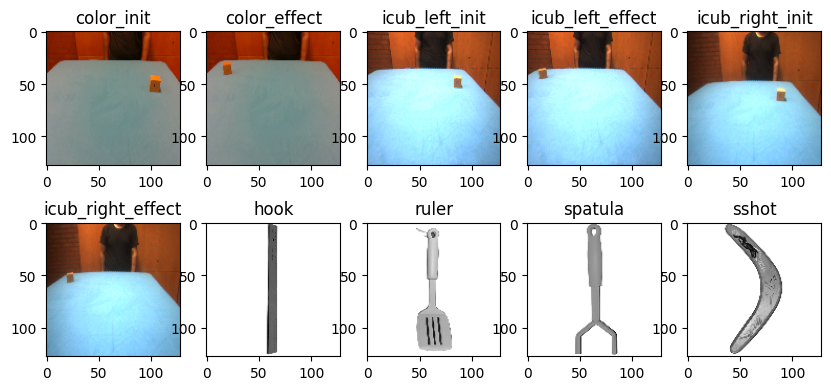

In [ ]:
image = validation_set[0]
# Display the first three channels in RGB
plt.figure(figsize=(10, 12))

plt.subplot(5, 5, 1)
plt.imshow(image[:, :, :3])
plt.title('color_init')

plt.subplot(5, 5, 6)
plt.imshow(image[:, :, 3:6])
plt.title('color_effect')

plt.subplot(5, 5, 2)
plt.imshow(image[:, :, 6:9])
plt.title('icub_left_init')

plt.subplot(5, 5, 7)
plt.imshow(image[:, :, 9:12])
plt.title('icub_left_effect')

plt.subplot(5, 5, 3)
plt.imshow(image[:, :, 12:15])
plt.title('icub_right_init')

plt.subplot(5, 5, 8)
plt.imshow(image[:, :, 15:18])
plt.title('icub_right_effect')

plt.subplot(5, 5, 4)
plt.imshow(image[:, :, 18],cmap='gray')
plt.title('hook')

plt.subplot(5, 5, 9)
plt.imshow(image[:, :, 19],cmap='gray')
plt.title('ruler')

plt.subplot(5, 5, 5)
plt.imshow(image[:, :, 20],cmap='gray')
plt.title('spatula')

plt.subplot(5, 5, 10)
plt.imshow(image[:, :, 21],cmap='gray')
plt.title('sshot')


plt.show()

# end

In [66]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
training_set, validation_set, test_set = [], [], []
# Initialize label encoders and one-hot encoders
tool_le = LabelEncoder()
action_le = LabelEncoder()
tool_ohe = OneHotEncoder()
action_ohe = OneHotEncoder()

# Fit the label encoders and one-hot encoders
tool_le.fit(toolnames)
action_le.fit(actions)
tool_ohe.fit(tool_le.transform(toolnames).reshape(-1, 1))
action_ohe.fit(action_le.transform(actions).reshape(-1, 1))

# Initialize lists to store the labels for each set
training_labels_1, validation_labels_1, test_labels_1 = [], [], []
training_labels_2, validation_labels_2, test_labels_2 = [], [], []
training_labels_3, validation_labels_3, test_labels_3 = [], [], []
training_tool, validation_tool, test_tool = [], [], []
training_action, validation_action, test_action = [], [], []
for a in range(len(objectnames)):
    objectname = objectnames[a]
    for y in range(len(toolnames)):
        toolname = toolnames[y]
        for x in range(len(actions)):
            action = actions[x]
            label_tool = tool_le.transform([toolname])[0]
            label_action = action_le.transform([action])[0]
            label_tool_action = label_tool * len(actions) + label_action
            onehot_tool = tool_ohe.transform(label_tool.reshape(-1, 1)).toarray()[0]
            onehot_action = action_ohe.transform(label_action.reshape(-1, 1)).toarray()[0]
            action = actions[x]
            label = actions.index(action)
            # Split into sets: 60% Training, 20% Validation, 20% Testing
            ids = np.random.choice(np.arange(10), 10, replace=False)
            training_ids, validation_ids, testing_ids = ids[0:6], ids[6:8], ids[8:10]
            # Loop through the number of repeats
            for j in range(10):
                sensor_images = []
                for i in range(len(sensornames)):
                    sensor = sensornames[i]
                    path = 'action_recognition_dataset/' + objectname + '/' + toolname + '/' + action + '/' + sensor + '/'
                    
                    if sensor == 'icub_right' or sensor == 'icub_left':
                        init = cv2.imread(path + 'init_color_' + sensor + '_' + str(j) + '.png')
                        effect = cv2.imread(path + 'effect_color_' + sensor + '_' + str(j) + '.png')
                    else:
                        init = cv2.imread(path + 'init_' + sensor + '_' + str(j) + '.png')
                        effect = cv2.imread(path + 'effect_' + sensor + '_' + str(j) + '.png')
                    
                    init = resize(init, width, height)
                    effect = resize(effect, width, height)
                    init = bgr_to_rgb(init)
                    effect = bgr_to_rgb(effect)
                    init = normalize(init)
                    effect = normalize(effect)
                    init = to_float(init)
                    effect = to_float(effect)
                    image = stack_channel(init, effect)
                    sensor_images.append(image)

                stacked_image = np.concatenate(sensor_images, axis=2)  # Stack the sensor images
                stacked_image = stack_with_tools(stacked_image)
                # stacked_image = np.expand_dims(stacked_image, axis=0)  # Add an extra dimension
            # rest of your code

                if j in training_ids:
                    training_set.append(stacked_image)
                    training_labels_1.append(label_tool)
                    training_labels_2.append(label_action)
                    training_labels_3.append(label_tool_action)
                    training_tool.append(onehot_tool)
                    training_action.append(onehot_action)
                    
                elif j in validation_ids:
                    validation_set.append(stacked_image)
                    validation_labels_1.append(label_tool)
                    validation_labels_2.append(label_action)
                    validation_labels_3.append(label_tool_action)
                    validation_tool.append(onehot_tool)
                    validation_action.append(onehot_action)
                elif j in testing_ids:
                    test_set.append(stacked_image)
                    test_labels_1.append(label_tool)
                    test_labels_2.append(label_action)
                    test_labels_3.append(label_tool_action)
                    test_tool.append(onehot_tool)
                    test_action.append(onehot_action)




(128, 128, 18) (128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128, 1)
(128, 128, 18) (128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128, 1)
(128, 128, 18) (128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128, 1)
(128, 128, 18) (128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128, 1)
(128, 128, 18) (128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128, 1)
(128, 128, 18) (128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128, 1)
(128, 128, 18) (128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128, 1)
(128, 128, 18) (128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128, 1)
(128, 128, 18) (128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128, 1)
(128, 128, 18) (128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128, 1)
(128, 128, 18) (128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128, 1)
(128, 128, 18) (128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128, 1)
(128, 128, 18) (128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128, 1)
(128, 128, 18) (128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128, 1)
(128, 

In [77]:
np.shape(validation_labels_1), np.shape(training_labels_2), np.shape(training_labels_3)

((64,), (192,), (192,))

In [76]:
training_labels_3

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15]

In [70]:
import torch
torch.save(training_set, 'training_set.pt')
torch.save(training_tool, 'training_tool.pt')
torch.save(training_action, 'training_action.pt')
torch.save(training_labels_1, 'training_labels_1.pt')
torch.save(training_labels_2, 'training_labels_2.pt')
torch.save(training_labels_3, 'training_labels_3.pt')

# Save validation data
torch.save(validation_set, 'validation_set.pt')
torch.save(validation_tool, 'validation_tool.pt')
torch.save(validation_action, 'validation_action.pt')
torch.save(validation_labels_1, 'validation_labels_1.pt')
torch.save(validation_labels_2, 'validation_labels_2.pt')
torch.save(validation_labels_3, 'validation_labels_3.pt')

# Save test data
torch.save(test_set, 'test_set.pt')
torch.save(test_tool, 'test_tool.pt')
torch.save(test_action, 'test_action.pt')
torch.save(test_labels_1, 'test_labels_1.pt')
torch.save(test_labels_2, 'test_labels_2.pt')
torch.save(test_labels_3, 'test_labels_3.pt')

In [ ]:
training_set, validation_set, test_set = [], [], []
for a in range(len(objectnames)):
    objectname = objectnames[a]
    for y in range(len(toolnames)):
        toolname = toolnames[y]
        for x in range(len(actions)):
            action = actions[x]
            label = actions.index(action)
            # Split into sets: 60% Training, 20% Validation, 20% Testing
            ids = np.random.choice(np.arange(10), 10, replace=False)
            training_ids, validation_ids, testing_ids = ids[0:6], ids[6:8], ids[8:10]
            # Loop through the number of repeats
            for j in range(10):
                sensor_images = []
                for i in range(len(sensornames)):
                    sensor = sensornames[i]
                    path = 'action_recognition_dataset/' + objectname + '/' + toolname + '/' + action + '/' + sensor + '/'
                    
                    if sensor == 'icub_right' or sensor == 'icub_left':
                        init = cv2.imread(path + 'init_color_' + sensor + '_' + str(j) + '.png')
                        effect = cv2.imread(path + 'effect_color_' + sensor + '_' + str(j) + '.png')
                    else:
                        init = cv2.imread(path + 'init_' + sensor + '_' + str(j) + '.png')
                        effect = cv2.imread(path + 'effect_' + sensor + '_' + str(j) + '.png')
                    
                    init = resize(init, width, height)
                    effect = resize(effect, width, height)
                    init = bgr_to_rgb(init)
                    effect = bgr_to_rgb(effect)
                    init = normalize(init)
                    effect = normalize(effect)
                    init = to_float(init)
                    effect = to_float(effect)
                    image = stack_channel(init, effect)
                    sensor_images.append(image)

                stacked_image = np.concatenate(sensor_images, axis=2)  # Stack the sensor images
                stacked_image = stack_with_tools(stacked_image)
                # stacked_image = np.expand_dims(stacked_image, axis=0)  # Add an extra dimension
                
                if j in training_ids:
                    training_set.append(stacked_image)
                elif j in validation_ids:
                    validation_set.append(stacked_image)
                elif j in testing_ids:
                    test_set.append(stacked_image)
